In [217]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt
import numpy as np
import time
from torch.optim.lr_scheduler import StepLR

In [2]:
device = torch.device("cuda:4" if torch.cuda.is_available() else "cpu")

In [3]:
def rand_tensor(min=0, max=1, size=(1)):
    out = (max - min) * torch.rand(size) + min
    return out

In [225]:
class Polynomial_func:
    def __init__(self, x, range=[-1,1], degree = 3, size=(1,1), sample_size=100, device="cuda"):
        self.x = x
        self.range = range
        self.degree = degree
        self.size = size
        self.sample_size = sample_size
        self.device = device

    def generate(self):
        hold = []
        for n in range(self.degree + 1):
            p = rand_tensor(
                min=self.range[0],
                max=self.range[1],
                size=(self.sample_size, self.size[0], self.size[1]),
            )
            hold.append(p)
        params = torch.stack(hold)
        params = torch.atleast_2d(params)
        params = torch.transpose(params, 0, 1)
        params = torch.transpose(params, 1, 2)
        params = params.to(self.device)

        x = (
            torch.cat(params.shape[0] * [self.x])
            .reshape(params.shape[0], -1)
            .to(self.device)
        )
        x = torch.transpose(x, 0, 1).to(self.device)
        y = torch.zeros_like(x)

        for d in range(self.degree+1):
            coeffs = params[:,0,d,0]
            y += coeffs*(x**d)
        out = torch.zeros(
                (params.shape[0], self.x.shape[0],
                self.size[0], self.size[1])
            ).to(self.device)            
        out[:,:,0,0] = torch.transpose(y,0,1)
        return torch.sum(out,dim=3), params.squeeze(1)


In [254]:
class Sin_func:
    def __init__(self, x, range=[-1,1], size=(1, 1), sample_size=1000, device="cuda"):
        self.x = x
        self.range = range
        self.size = size
        self.sample_size = sample_size
        self.device = device

    def generate(self):
        amp = rand_tensor(
            min=self.range[0],
            max=self.range[1],
            size=(self.sample_size, self.size[0], self.size[1]),
        ).to(self.device)
        freq = rand_tensor(
            min=self.range[0],
            max=self.range[1],
            size=(self.sample_size, self.size[0], self.size[1]),
        ).to(self.device)
        phase = rand_tensor(
            min=self.range[0],
            max=self.range[1],
            size=(self.sample_size, self.size[0], self.size[1]),
        ).to(self.device)
        
        params = torch.stack((amp, freq, phase))
        params = torch.atleast_2d(params)
        params = torch.transpose(params, 0, 1)
        params = torch.transpose(params, 1, 2)
        params = params.to(self.device)

        x = (
            torch.cat(params.shape[0] * [self.x])
            .reshape(params.shape[0], -1)
            .to(self.device)
        )
        x = torch.transpose(x, 0, 1).to(self.device)
        y =  params[:,0,0,0] * torch.sin(2 * torch.pi * params[:,0,1,0] * x + params[:,0,2,0])
        out = torch.zeros(
                (params.shape[0], self.x.shape[0],
                self.size[0], self.size[1])
            ).to(self.device)  
        out[:, :, 0, 0] = torch.transpose(y, 0, 1)
        return torch.sum(out, dim=3), params.squeeze(1)

In [218]:
class PairedDataset(Dataset):
    def __init__(self, x_data, y_data):
        assert len(x_data) == len(y_data), "Datasets must be of the same length"
        self.x_data = x_data
        self.y_data = y_data

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        x = self.x_data[idx]
        y = self.y_data[idx]
        return x, y

In [274]:
sample_size = 10000
sequence_length = 1000
batch_size = 10
data_range = [-1, 1]
num_funcs = 4

x_values = torch.linspace(data_range[0], data_range[1], sequence_length)

linear = Polynomial_func(x=x_values, range=data_range, degree=1, sample_size=sample_size, device=device)
lin_full, lin_params = linear.generate()

quad = Polynomial_func(x=x_values, range=data_range, degree=2, sample_size=sample_size, device=device)
quad_full, quad_params = quad.generate()

cube = Polynomial_func(x=x_values, range=data_range, degree=3, sample_size=sample_size, device=device)
cube_full, cube_params = cube.generate()

sin = Sin_func(x=x_values, range=data_range, sample_size=sample_size, device=device)
sin_full, sin_params = sin.generate()

'''print(cube_full.shape)
#data = torch.cat([cube_full.squeeze(2), quad_full.squeeze(2), lin_full.squeeze(2), sin_full.squeeze(2)], dim=0)
data = torch.cat([cube_full, quad_full, lin_full, sin_full], dim=2)
print(data.shape)
data = data.permute(2,0,1)
#data = data.T
#print(data.shape)
data = data.reshape(-1, sequence_length, 1)
print(data.shape)'''
'''new_data = []
data_tensors = [cube_full, quad_full, lin_full, sin_full]
for f in range(sample_size):
    for i in range(num_funcs):
        new_data.append(data_tensors[i][f])
new_data = torch.stack(new_data)
print(new_data.shape)'''

padded_quad = torch.zeros(10000, 4, 1)
padded_quad[:, :3, :] = quad_params

padded_lin = torch.zeros(10000, 4, 1)
padded_lin[:, :2, :] = lin_params

padded_sin = torch.zeros(10000, 4, 1)
padded_sin[:, :3, :] = sin_params

other_data = torch.vstack([cube_full, quad_full, lin_full, sin_full])
all_params = torch.vstack([cube_params.to(device), padded_quad.to(device), padded_lin.to(device), padded_sin.to(device)])
dataset = PairedDataset(other_data, all_params)
all_data = DataLoader(dataset, batch_size=batch_size, shuffle=True)

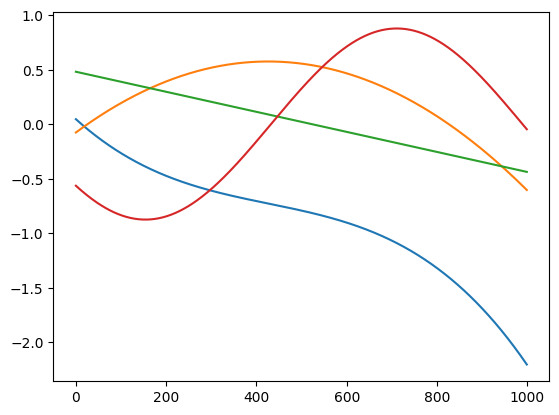

In [15]:
plt.plot(new_data[0, :, 0].detach().cpu().numpy(), "-")
plt.plot(new_data[1, :, 0].detach().cpu().numpy(), "-")
plt.plot(new_data[2, :, 0].detach().cpu().numpy(), "-")
plt.plot(new_data[3, :, 0].detach().cpu().numpy(), "-")

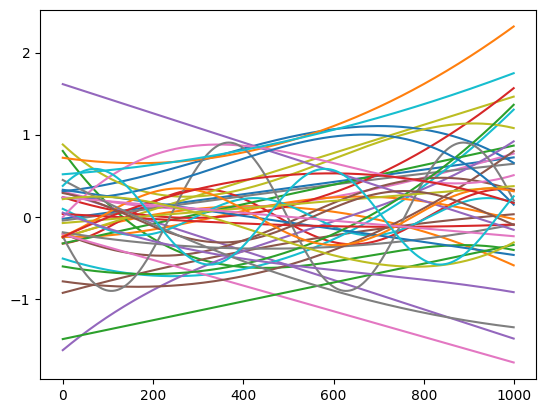

In [10]:
for i in range(10):
    r = np.random.randint(sample_size)
    plt.plot(lin_full[r, :, 0].detach().cpu().numpy(), "-")
    plt.plot(quad_full[r, :, 0].detach().cpu().numpy(), "-")
    plt.plot(cube_full[r, :, 0].detach().cpu().numpy(), "-")
    plt.plot(sin_full[r, :, 0].detach().cpu().numpy(), "-")

In [56]:
def linear_function(params, x, device):
    x = x.to(device)
    if params.size(1) > 1:
        a = params[:, 0].type(torch.float).unsqueeze(1).to(device)
        b = params[:, 1].type(torch.float).unsqueeze(1).to(device)
        return a*x + b
    else:
        print("Linear function requires at least 2 parameters")
        return torch.ones_like(params)*1e6

def quadratic_function(params, x, device):
    params = params.to(device)
    x = x.to(device)
    y = torch.zeros((params.size(0),x.shape[0])).to(device)
    if params.size(1) > 2:
        for n in range(len(params[0])):
            y += (params[:, n].type(torch.float).unsqueeze(1).to(device))*x**(3-n)
        return y
    else:
        print("Quadratic function requires at least 3 parameters")
        return torch.ones_like(params)*1e6

def cubic_function(params, x, device):
    params = params.to(device)
    x = x.to(device)
    y = torch.zeros((params.size(0),x.shape[0])).to(device)
    if params.size(1) > 3:
        for n in range(len(params[0])):
            y += (params[:, n].type(torch.float).unsqueeze(1).to(device))*x**(3-n)
        return y
    else:
        print("Cubic function requires at least 4 parameters")
        return torch.ones_like(params)*1e6
    
def sin_function(params, x, device):
    x = x.to(device)
    if params.size(1) == 3:
        amplitude = params[:, 0].type(torch.float).unsqueeze(1).to(device)
        frequency = params[:, 1].type(torch.float).unsqueeze(1).to(device)
        phase = params[:, 2].type(torch.float).unsqueeze(1).to(device)
        return amplitude * torch.sin(2 * torch.pi * frequency * x + phase)
    else:
        print("Sin function requires 3 parameters")
        return torch.ones_like(params)*1e6

In [211]:
def new_loss(output, target, x_vals):
    #print(x.shape)
    #print(target.shape)
    #print(output.shape)
    target_range = torch.max(target, dim=-1, keepdim=True)[0] - torch.min(target, dim=-1, keepdim=True)[0]
    target_range = torch.clamp(target_range, min=1e-6).squeeze(-1)
    #print(f"target_range: {target_range}")
    #x = x.clone().detach().requires_grad_(True)
    #target = target.clone().detach().requires_grad_(True)
    output = output.clone().requires_grad_(True)
    target = target.clone().requires_grad_(True)
    x_vals = x_vals.clone().requires_grad_(True)
    print(f"x_vals requires grad: {x_vals.requires_grad}")
    print(f"output requires grad: {output.requires_grad}")
    print(f"target requires grad: {target.requires_grad}")
    derivative_true = torch.autograd.grad(outputs=target, inputs=x_vals, grad_outputs=torch.ones_like(target), allow_unused=True)[0]
    if derivative_true is None:
        derivative_true = torch.zeros_like(output)
        print("derivative_true is None")
    
    derivative_pred = torch.autograd.grad(outputs=output, inputs=x_vals, grad_outputs=torch.ones_like(target), allow_unused=True)[0]
    if derivative_pred is None:
        derivative_pred = torch.zeros_like(output)
        print("derivative_pred is None")

    #derivative_true = (torch.roll(target, shifts=-1, dims=1) - torch.roll(target, shifts=1, dims=1)) / (2 * 1e-8)
    #derivative_pred = (torch.roll(output, shifts=-1, dims=1) - torch.roll(output, shifts=1, dims=1)) / (2 * 1e-8)
    
    mse_function = torch.mean(torch.abs(target - output)**4, dim=1)/target_range
    mse_derivative = torch.mean(torch.abs(derivative_pred - derivative_true)**2, dim=1)#/target_range
    
    #print(f"target_range: {target_range}")
    print(f"derivative_true: {derivative_true}")
    print(f"derivative_pred: {derivative_pred}")
    #print(f"mse_function: {mse_function}")
    #print(f"mse_derivative: {mse_derivative}")
    
    return mse_function + mse_derivative


In [288]:
class Encoder(nn.Module):
    def __init__(self, 
                 x_data,
                 functions,
                 device="cuda",
                 sequence_length=96, 
                 input_channel=2, 
                 cov1d_size=128,
                 drop_out=0.1):
        super(Encoder, self).__init__()
        self.x_data = x_data
        self.functions = functions
        self.device = device
        self.num_params = sum(self.functions[1])
        
        self.cov1d = nn.Conv1d(input_channel, cov1d_size, 3, stride=1, padding=1)
        self.flattened_size = cov1d_size * sequence_length
        self.dense = nn.Linear(self.flattened_size, self.num_params)
        
        self.selu_1 = nn.SELU()

    def forward(self, x):#, params):
        #print(f"initial x: {x}")
        out = self.cov1d(x)
        #print(f"after cov1d: {out}")        
        out = out.reshape(out.size(0), -1)
        #print(f"after flatten: {out}")
        out = self.dense(out)
        #print(f"after dense: {out}")
        out = self.selu_1(out)
        #print(f"after selu: {out}")

        #loss_func = nn.MSELoss()
        start_index = 0
        losses = []
        outputs = []
        
        '''param_padding = (params != 0).any(dim=0).any(dim=1)
        params_zeroless = params[:, param_padding, :]
        print(f"params in: {params_zeroless.shape}")
        targets = self.functions[0][f](
            params_zeroless, 
            self.x_data, 
            device=self.device
        ).to(device)
        print(f"targets: {targets.shape}")'''

        for f in range(len(self.functions[0])):
            #print(f"parameters: {out[:, start_index:start_index+self.functions[1][f]].shape}")
            #print(f"function: {self.functions[0][f]}")
            #print(f"params: {out[:, start_index:start_index+self.functions[1][f]]}")
            #print(f"x: {self.x_data}")
            output = self.functions[0][f](
                out[:, start_index:start_index+self.functions[1][f]], 
                self.x_data, 
                device=self.device
            ).to(device)
            print(f"output: {output.shape}")
            outputs.append(output)
            loss = new_loss(output, x.squeeze(1), self.x_data)
            #print(f"loss: {loss[5]}")
            losses.append(loss)
            start_index += self.functions[1][f]        
        
        '''best_index = torch.argmin(torch.tensor(losses))
        best_func = self.functions[0][best_index]
        best_loss, best_out = losses[best_index], outputs[best_index]'''
        '''for i, output in enumerate(outputs):
            print(f"Output from function {i}: {output[0]}")
        for i, loss in enumerate(losses):
            print(f"Loss from function {i}: {loss[0]}")'''

        #print(f"outputs list: {outputs}")
        #print(f"losses list: {losses}")
        stacked_outputs = torch.stack(outputs)
        stacked_losses = torch.stack(losses)
        '''print(f"stacked_losses: {stacked_losses}")
        print(f"stacked_losses linear: {stacked_losses[0].shape}")
        print(f"linear all: {stacked_losses[0]}")
        print(f"quadratic all: {stacked_losses[1]}")
        print(f"cubic all: {stacked_losses[2]}")
        print(f"sin all: {stacked_losses[3]}")
        print(f"linear: {stacked_losses[0, 0]}")
        print(f"quadratic: {stacked_losses[1, 0]}")
        print(f"cubic: {stacked_losses[2, 0]}")
        print(f"sin: {stacked_losses[3, 0]}")'''
        #print(f"outputs: {outputs.shape}")
        #print(f"losses: {losses.shape}")
        best_loss, best_indexes = torch.min(stacked_losses, dim=0) 
        print(f"stacked_losses for 0: {stacked_losses[:, 0]}")
        #print(f"best_loss: {best_loss[0]}")
        #print(f"best_indexes: {best_indexes[0]}")
        best_out = stacked_outputs[best_indexes, -1]
        #print(f"best_out: {best_out.shape}")
        best_func = [self.functions[0][idx] for idx in best_indexes]
        print(f"best_func for 0: {best_func[0]}")

        return best_out, best_loss, best_func, stacked_outputs, stacked_losses

In [289]:
functions = [[linear_function, quadratic_function, cubic_function, sin_function], [2,3,4,3]]
model = Encoder(x_data=x_values, functions=functions, device=device, sequence_length=sequence_length, input_channel=1, cov1d_size=128).to(device)

In [290]:
for train_batch, params in all_data:
    train_batch = torch.swapaxes(train_batch, 1, 2).to(device)
    train_batch.requires_grad_(True)
    best_out, best_loss, best_func, stacked_outputs, stack_losses = model(train_batch)#, params)
    break


output: torch.Size([10, 1000])
x_vals requires grad: True
output requires grad: True
target requires grad: True
derivative_true is None
derivative_pred is None
derivative_true: tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:4')
derivative_pred: tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:4')
output: torch.Size([10, 1000])
x_vals requires grad: True
output requires grad: True
target requires grad: True
derivative_true is None
derivative_pred is None
derivative_true: tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
       

In [205]:
loss_func = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

In [206]:
epochs = 10
for epoch in range(epochs):
    start_time = time.time()
    train_loss = 0.0
    total_num = 0
    model.train()
    
    for train_batch in all_data:
        train_batch = torch.swapaxes(train_batch, 1, 2).to(device)
        train_batch.requires_grad_(True)
        target_batch = train_batch.squeeze(1).to(device)
        optimizer.zero_grad()
        best_out,_,_,_,_ = model(train_batch)
        loss = loss_func(best_out,target_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * best_out.shape[0]
        total_num += best_out.shape[0]
    scheduler.step()
    train_loss /= total_num
    print(f"epoch : {epoch}/{epochs}, loss = {train_loss:.8f}")
    print(f"--- {time.time() - start_time} seconds ---")

stacked_losses for 0: tensor([1.0187, 3.7358, 4.8280, 2.2064], device='cuda:4',
       grad_fn=<SelectBackward0>)
best_func for 0: <function linear_function at 0x7f456e7b5620>
stacked_losses for 0: tensor([4.3400e+10, 1.0200e+09, 4.2887e+02, 5.0677e+09], device='cuda:4',
       grad_fn=<SelectBackward0>)
best_func for 0: <function cubic_function at 0x7f456e7b5800>
stacked_losses for 0: tensor([3.5854e+10, 8.4319e+08, 1.5969e+02, 4.2088e+09], device='cuda:4',
       grad_fn=<SelectBackward0>)
best_func for 0: <function cubic_function at 0x7f456e7b5800>
stacked_losses for 0: tensor([1.1841e+11, 1.9814e+10, 1.3582e+02, 9.6858e+10], device='cuda:4',
       grad_fn=<SelectBackward0>)
best_func for 0: <function cubic_function at 0x7f456e7b5800>
stacked_losses for 0: tensor([9.0077e+12, 1.0905e+12, 4.4343e+02, 5.2715e+12], device='cuda:4',
       grad_fn=<SelectBackward0>)
best_func for 0: <function cubic_function at 0x7f456e7b5800>
stacked_losses for 0: tensor([1.6086e+11, 1.8356e+11, 2.3977

KeyboardInterrupt: 

In [207]:
t_sample_size = 100

t_x_values = torch.linspace(-1, 1, 1000)
t_linear = Polynomial_func(x=x_values, range=[-1,1], degree=1, sample_size=t_sample_size, device=device)
t_quad = Polynomial_func(x=x_values, range=[-1,1], degree=2, sample_size=t_sample_size, device=device)
t_cube = Polynomial_func(x=x_values, range=[-1,1], degree=3, sample_size=t_sample_size, device=device)
t_sin = Sin_func(x=x_values, range=data_range, sample_size=t_sample_size, device=device)

t_lin_full = t_linear.generate()
t_quad_full = t_quad.generate()
t_cube_full = t_cube.generate()
t_sin_fulll = t_sin.generate()


t_data = torch.swapaxes(torch.vstack([t_lin_full, t_quad_full, t_cube_full, t_sin_fulll]), 1, 2)

In [236]:
a = torch.tensor([0, 4, 8, 12]).unsqueeze(1).unsqueeze(2)
b = torch.tensor([1, 5, 9, 13]).unsqueeze(1).unsqueeze(2)
c = torch.tensor([2, 6, 10, 14]).unsqueeze(1).unsqueeze(2)
d = torch.tensor([3, 7, 11, 15]).unsqueeze(1).unsqueeze(2)

print(a.shape)
stacked = torch.cat([a, b, c, d], dim=1)
transposed = stacked.permute(2, 0, 1).reshape(-1, 1, 1)
print("Shape of resulting tensor:", transposed.shape)
print(transposed[0, : , 0])
print(transposed[1, : , 0])
print(transposed[2, : , 0])
print(transposed[3, : , 0])



torch.Size([4, 1, 1])
Shape of resulting tensor: torch.Size([16, 1, 1])
tensor([0])
tensor([1])
tensor([2])
tensor([3])


In [208]:
model.eval()
best_out, best_loss, best_func, outputs, losses = model(t_data)

best_func: <function sin_function at 0x7fd876cee7a0>


<function sin_function at 0x7fd876cee7a0>
tensor([3.0701e+00, 1.3653e+24, 9.6642e+27, 4.9501e-01], device='cuda:4',
       grad_fn=<SelectBackward0>)
tensor(0.4950, device='cuda:4', grad_fn=<SelectBackward0>)


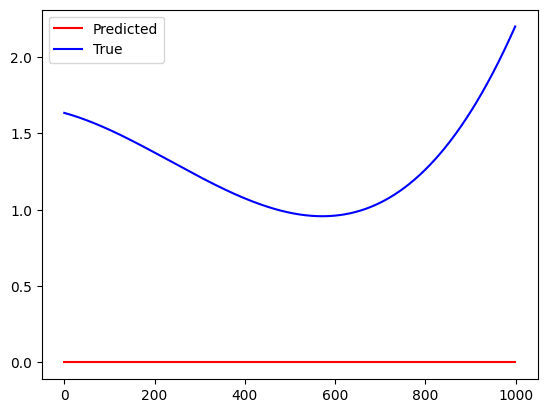

In [222]:
rand = np.random.randint(t_sample_size*num_funcs)
print(best_func[rand])
print(losses[:,rand])
print(best_loss[rand])
plt.plot(best_out[rand].detach().cpu().numpy(), "r", label='Predicted')
plt.plot(t_data.squeeze(1)[rand].detach().cpu().numpy(), "b", label='True')
plt.legend();